# GLIMPSE INTO TWITTER's FUTURE

As Twitter continues to evolve and adapt to the ever-changing landscape of the digital world, it's difficult to predict exactly what the future holds for the popular social media platform. One thing is certain, however: Twitter will continue to be a valuable tool for people to connect with each other and share their thoughts, ideas, and opinions.

In the future, we may see Twitter incorporate even more advanced features, such as virtual reality integration or personalized AI assistants to help users manage their feeds and connect with others more easily. The platform may also continue to crack down on cyberbullying and hate speech, creating a safer and more inclusive environment for all users.

As more and more people turn to social media to stay informed and connected, Twitter will undoubtedly play a crucial role in shaping the global conversation. Whether it's breaking news, discussions on important issues, or simply a funny meme, Twitter will remain a vibrant and influential platform for people around the world.

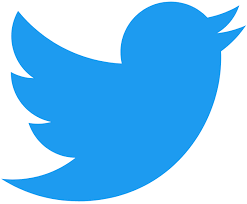

But, we aren't the future of Data Science for null!
We will be attempting to Predict the Tweets for Celebrities and Do a sentiment analysis of it.

TEAM OUTLIERS:

* Nanda Krishna
* Dewang Vinchhi
* Prayash Panda
* Shishir Tripathi

In [ ]:
!pip install transformers snscrape datasets -q

     |████████████████████████████████| 5.8 MB 4.7 MB/s 
     |████████████████████████████████| 59 kB 5.8 MB/s 
     |████████████████████████████████| 451 kB 62.4 MB/s 
     |████████████████████████████████| 182 kB 51.2 MB/s 
     |████████████████████████████████| 7.6 MB 66.6 MB/s 
     |████████████████████████████████| 132 kB 38.7 MB/s 
     |████████████████████████████████| 212 kB 52.6 MB/s 
     |████████████████████████████████| 127 kB 61.5 MB/s 


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import os 
import matplotlib.pyplot as plt
import seaborn as sbn
import pickle
import tensorflow as tf 
import time
import json 
from collections import deque, Counter

from tqdm import tqdm, trange
from glob import glob
from snscrape.modules import twitter
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer, DataCollatorForLanguageModeling
from datasets import Dataset
from transformers import pipeline
from itertools import cycle 
from numba import cuda 

print("Pandas version {pd.__version__}")
print(f"Numpy version {np.__version__}")
print(f"Tensorflow version {tf.__version__}")

Pandas version {pd.__version__}
Numpy version 1.21.6
Tensorflow version 2.9.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Thu Dec 15 13:13:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Part 1: Tweet Generation Based on User tweets

## 1.1 Scraping Tweets Using TweePy

Following Steps are used to scrape the tweets using scnscrape library

- Get the `user_ids` from tweeter client api
- Use those ids to get past 1000 tweets of the user from snscrape `TwitterUserScraper` function

In [ ]:
# MAKING CONNECTION WITH THE TWITTER CLIENT

PROJECT_DIRECTORY = '/content/drive/MyDrive/AI_3_PROJECT_DEVANG/'

with open(f'{PROJECT_DIRECTORY}/Copy of twitterAppCred.json', 'r') as fp:
    credentials = json.load(fp)

cli = tweepy.Client(bearer_token = credentials['bearer_token'])

In [ ]:
# IMPORTING THE FILE CONTAINING THE USERNAMES OF TWITTER ACCOUNTS

userNames = pd.read_csv(f"{PROJECT_DIRECTORY}/tweeter_username.csv").iloc[:, 0]

print(f"There are {userNames.duplicated().sum()} number of duplicate user names")

userNames.drop_duplicates(inplace=True)
print("Duplicates dropped.")

userNames[:10]

There are 10 number of duplicate user names
Duplicates dropped.


0        katyperry
1     justinbieber
2    taylorswift13
3          rihanna
4         ladygaga
5      jtimberlake
6     TheEllenShow
7    britneyspears
8        Cristiano
9    KimKardashian
Name: twitter, dtype: object

In [ ]:
# USING THE TWITTER CLIENT API TO GET ALL THE USER-IDS
# AND THOSE IDS OR ACCOUNTS WHICH ARE SUSPENDED

twitter_unique_id = list()
ids_not_found = list()

for i in range((len(userNames) // 100)+1):
    idx = i * 100

    # The '.get_users' function takes in string of comma separated usernames
    # Below we create them
    uname_values = ''
    for val in list(userNames[idx : idx+100]):
        uname_values += (val+',')

    # Getting the user ids
    print("Finished :", len(userNames[idx : idx+100]))
    resp = cli.get_users(usernames = uname_values[:-1])
    
    # storing the user ids
    twitter_unique_id.extend(
        [val.id for val in resp.data]
    )
    ids_not_found.extend(
        [val["value"] for val in resp.errors]
    )

100
100
100
100
100
100
100
100
100
86


In [ ]:
all_tweets = deque()
NUM_OF_TWEETS_SCRAPE = 1000
ids_with_error = list()
batch_size = 20

for u_id_idx in range(0, len(twitter_unique_id), batch_size):
    u_ids_batch = twitter_unique_id[u_id_idx : u_id_idx + batch_size]
    
    for i in trange(batch_size):
        u_id = u_ids_batch[i]
        
        # If there are any errors, totally ignore that
        try:
            for num, tweet in enumerate(twitter.TwitterUserScraper(u_id).get_items()):
                all_tweets.append([
                    tweet.date, 
                    u_id, 
                    tweet.user.username,
                    tweet.rawContent
                ])
                if num == NUM_OF_TWEETS_SCRAPE - 1:
                    break
        except:
            ids_with_error.append( u_id )
            continue

    print(f"\nFinished scraping {u_id_idx + batch_size} number of users")
    print(f"Length of all_tweets is {len(all_tweets)}")
    all_tweets = pd.DataFrame(all_tweets, 
                     columns = [
                         "date",
                         "user_id",
                         "username",
                         "tweet",
                     ])
    
    part_no = u_id_idx // batch_size
        
    all_tweets.to_pickle(f"{PROJECT_DIRECTORY}tweets_df_part{part_no}.pkl")
    all_tweets = deque()


In [ ]:
# Code to combine all the parts of user tweets scraped.

files_path = glob(f"{PROJECT_DIRECTORY}/tweets_df_part*.pkl")

tweeter_df = pd.DataFrame()

# joining all the pickle files and creating one dataframe
for p in files_path:
    tweeter_df = pd.concat([
        tweeter_df,        
        pd.read_pickle( p )   ], 
        
    ignore_index=True
    )


## 1.2 Preprocessing the Tweets

### OBSERVATION
- There are many tweets that are not in English language. We keep ourselves limited to only English language
- There are also emoticons that are used extensively to express emotions and maybe for simple decorative purposes.

### Decisions
- We remove other language tweets
- Emoticons are removed as GPT2 does not have vocabulary of emoticons

In [ ]:
# Taking a look at the data scraped.

tweeter_df.head()

,date,user_id,username,tweet
0,2022-11-27 00:17:22+00:00,789856765,cuervotinelli,Los amoooooo❤️⚽️⚽️💪🏻🇦🇷
1,2022-11-27 00:12:27+00:00,789856765,cuervotinelli,QUE GOLAZO POR DIOS!! VAMOS ARGENTINA CARAJOOO...
2,2022-11-27 00:04:51+00:00,789856765,cuervotinelli,Impresionante. Vamoooooos ARGENTINA CARAJOOOO⚽...
3,2022-11-24 09:54:44+00:00,789856765,cuervotinelli,Jajajajajaja noooooo. No mientan amigos. Estoy...
4,2022-10-22 22:59:45+00:00,789856765,cuervotinelli,Gracias por la aclaración. https://t.co/LoJxXv...


In [ ]:
# The total number of tweets in the data.

tweeter_df.shape

(486127, 4)

Number of tweets for each user

In [ ]:
# Top tweeterattis

tweeter_df['username'].value_counts()[:20]

cuervotinelli      1000
AdelAliBinAli      1000
ShawnMendes        1000
amrdiab            1000
SandraDewi88       1000
RevRunWisdom       1000
NoelSchajris       1000
wisinyyandel       1000
neiltyson          1000
DONOMAR            1000
luckymanzano       1000
SalehAlmoghamsy    1000
micheltelo         1000
MarceloM12         1000
gadelmaleh         1000
imdanielpadilla    1000
IrfanBachdim10     1000
iamjamiefoxx       1000
CP3                1000
MonsieurDream      1000
Name: username, dtype: int64

In [ ]:
# Function to clean out the unwanted elements in the dataframe.

def clean_data(dataframe):
    '''
    Input = DataFrame of tweets
    Operations: for each tweet
    - Convert to lowercase
    - Removes URLs
    - Remove punctuations, emoticons and newline characters
    Returns dataframe with all the operations performed
    '''
    new_df = dataframe.copy()
    new_df = new_df.str.lower()
    
    for i in range(len(new_df)):
      
      # Removing URLs
      new_df.loc[i] = re.sub(r"http\S+","", new_df.loc[i])

      # Removing NewLine Characters
      new_df.loc[i] = re.sub("\n","", new_df.loc[i])

      # Removing punctuations and numbers
      new_df.loc[i] = re.sub("[^\w\s]+","", new_df.loc[i])
    
    return new_df

In [ ]:
tweeter_df['tweet'] = clean_data(tweeter_df['tweet'])
tweeter_df['tweet'].head()

0                                         los amoooooo
1         que golazo por dios vamos argentina carajooo
2         impresionante vamoooooos argentina carajoooo
3    jajajajajaja noooooo no mientan amigos estoy s...
4                           gracias por la aclaración 
Name: tweet, dtype: object

## 1.2.1 Filtering the user tweets based on language and length

In [ ]:
# Selecting users who tweet in English-Only.

Needed_users = ['CalvinHarris', 'richardbranson', 'ciara',
       'SteveMartinToGo', 'ZooeyDeschanel', 'KELLYROWLAND', 'Fearnecotton',
       'rioferdy5', 'FloydMayweather', 'katyperry', 'justinbieber', 'taylorswift13',
       'rihanna', 'ladygaga', 'jtimberlake', 'TheEllenShow',
       'britneyspears', 'KimKardashian', 'shakira',
       'selenagomez', 'JLo', 'ddlovato', 'jimmyfallon', 'Oprah', 'Pink',
       'Drake', 'Harry_Styles', 'onedirection', 'BillGates', 'KingJames',
       'LilTunechi', 'BrunoMars', 'KAKA', 'Adele', 'NiallOfficial',
       'MileyCyrus', 'aliciakeys', 'KevinHart4real', 'wizkhalifa',
       'pitbull', 'Louis_Tomlinson', 'NICKIMINAJ', 'Eminem',
       'AvrilLavigne', 'ActuallyNPH', 'danieltosh', 'davidguetta',
       'ConanOBrien', 'SrBachchan', 'aplusk', 'khloekardashian',
       'kourtneykardash', 'zaynmalik', 'iamsrk', 'coldplay',
       'MariahCarey', 'edsheeran', 'JimCarrey', 'chrisbrown',
       'BeingSalmanKhan', 'LeoDiCaprio', 'ParisHilton',
       'iamwill',  'KendallJenner', 'ashleytisdale',
       'SnoopDogg', 'SimonCowell', 'WayneRooney', 'KDTrey5', 'maroon5',
       'KylieJenner','deepikapadukone', 'charliesheen','iHrithik', 'priyankachopra',
       'ZacEfron', 'carlyraejepsen', 'rustyrockets','Ludacris',
       'SHAQ', 'tomhanks', 'Usher', 'akshaykumar', 'rickygervais','nickjonas', 'TheRock',
       'StephenAtHome', 'VictoriaJustice','lindsaylohan', 'arrahman', 'AustinMahone', 'victoriabeckham',
       'TreySongz', 'SofiaVergara', 'jessicaalba', 'realwbonner', 'imVkohli', 'JessieJ',
       'annecurtissmith', 'sachin_rt','SethMacFarlane', 'thalia', 'MarcAnthony',
       '50cent', 'Pharrell', 'joejonas', 'BigSean', 
       '5SOS', 'kobebryant', 'davidbisbal', 'juniorbachchan', 'Tatawerneck', 'channingtatum',
       'Persie_Official', 'sonamakapoor', 'CodySimpson',
       'GarethBale11', 'JohnCena', 'JColeNC','MirandaCosgrove', 
       'johnlegend', 'EvaLongoria','CherLloyd', 'JessicaSimpson', 'NancyAjram', 'SpiderAnderson',
       'montanertwiter', 'LittleMix', 'carmeloanthony', 'SarahKSilverman',
       'shahidkapoor', 'Tyga', 'ChespiritoRGB', 'snooki', 'FarOutAkhtar',
       'jennettemccurdy','bellathorne', 'hollywills', 'Tip', 'PerezHilton', 'DwightHoward',
       'CHAYANNEMUSIC', 'aliaa08', 'Zendaya', 'DulceMaria', 'iansomerhalder', 'KrisJenner',
       'jimmykimmel', 'RealHughJackman', 'IGGYAZALEA', 'AnushkaSharma', 'robkardashian', 'Akon',
       'ninadobrev','SonakshiSinha', 'chetan_bhagat', 'Calum5SOS', 'CH14_', 'jk_rowling', 'official_flo',
       'chelseahandler', 'atademirer', 'ScottDisick', 'CherylOfficial',
       'ParineetiChopra', 'RobertDowneyJr','jimmycarr', 'TomCruise', 'kendricklamar', 'serenawilliams',
       'Residente', 'adamlevine', 'CarlosLoret', 'JeremyClarkson',
       'ahickmann', 'VanessaHudgens', 'JKCorden', 'Michael5SOS', 'elliegoulding', 'camerondallas',
       'raisa6690', 'lilyallen', 'AnupamPKher', 'MichelleObama', 'maryjblige', 'oserginho',
       'justdemi', 'bernardokath', 'SamuelLJackson', 'NicoleScherzy',
       'bep', 'okanbayulgen', 'amrkhaled', 'MeekMill',
       'antanddec', 'RitaOra', 'lulopilato', 'Fiuk', 'NickCannon',
       'bepe20s', 'SandyLeah', 'mirandalambert', 'Angelluisr',
       'Nashgrier', 'bclsinclair', 'DemetAkalin', 'YengPLUGGEDin',
       'mindykaling', 'MacMiller', 'D_DeGea', 'juanmata8', 'TigerWoods',
       'MikeTyson', 'LennyKravitz', 'kevinjonas', 'DwyaneWade',
       'nicolerichie', 'linkinpark', 'HilaryDuff', 'ImRaina',
       'RNTata2000', 'ariyoshihiroiki', 'IBGDRGN', 'AnnaKendrick47',
       'wossy', 'lucyhale', 'bridgitmendler', 'donghae861015',
       'JohnCleese', 'souljaboy', 'PrinceRoyce', 'carrieunderwood',
       'jesseyjoy', 'yokoono', 'olla_ramlan', 'DjokerNole', 'gabyespino',
       'Bellaudyaa', 'tyleroakley', 'johngreen', 'BillSimmons',
       'llcoolj', 'facufacundo', 'iamsuperbianca',
       'msdhoni', 'piersmorgan', 'Skrillex', 'virendersehwag',
       'gitagut', 'Lord_Sugar', 'MonsieurDream', 'CP3',
       'iamjamiefoxx', 'IrfanBachdim10', 'kc_concepcion',
       'imdanielpadilla', 'gadelmaleh', 'micheltelo',
       'SalehAlmoghamsy', 'luckymanzano', 'DONOMAR', 'SteveCarell',
       'neiltyson', 'wisinyyandel', 'NoelSchajris', 'RevRunWisdom',
       'SandraDewi88', 'amrdiab', 'ShawnMendes', 'syntekoficial',
       'AdelAliBinAli', 'polo_polo', 'GloriaTrevi', 'TheVijayMallya',
       'Ashton5SOS', 'Wale', 'ChinoyNacho', 'Riteishd', 'PretaGil',
       'TomCavalcante1', 'RandyOrton', 'djkingassassin', 'gadiiing',
       'DJPaulyD', 'KevinSpacey', 'OzzyOsbourne', 'AdamSchefter', 'GaryLineker', 'VhongX44',
       'JordinSparks', 'rainnwilson', 'QueenRania', 'hulyavsar', 'najwakaram',
       'DebbouzeJamel', 'ajaydevgn', 'indrabektiasli',
       'MirandaKerr', 'fayez_malki', 'angelicaksy', 'GaryBarlow',
       'TheShilpaShetty', 'aristeguicnn', 'BillCosby', 'tonyhawk',
       'noaheverett', 'AndreaLegarreta', 'tylerperry', 'julietav',
       'bipsluvurself', 'psy_oppa', 'Caradelevingne', 'Nelly_Mo',
       'KellyOsbourne', 'YordiRosado', 'eddieizzard', 
       'cuneytozdemir', 'JoelOsteen', 'dylanobrien', 'diegotorres',
       'KeriHilson', 'realpreityzinta', 'rogerfederer',
       'GreenDay','carlosvives', 'jackwhitehall', 'alyankovic', 'alexoficial', 'MaiteOficial', 'shreyaghoshal',
       'LAURAGII', 'wyclef', 'scooterbraun', 'Adela_Micha', 'tiesto', 'paramore',
       'apriliokevin', 'AshBenzo', 'urgantcom', 'NormanDesVideos',
       'iyavillania', 'usainbolt', 'lancearmstrong', 'paulwesley',
       'LuisChataing', 'paulpierce34', 'hitRECordJoe',
       'MadhuriDixit', 'IAMJHUD', 'mcuban', 'DrOz','belindapop', 'JoyceMeyer', 'ValeYellow46', 'Poconggg',
       'jimjonescapo','joelmchale', 'jaimecamil', 'acunilicali', 'alinebarros',
       'OfficialWillow', 'ahmethc', 'bigtimerush', 'Schofe', 'pamyurin', 'EmilyOsment',
       'samuelmilby', 'FinallyMario', 'DollyParton', 'ChrisMoyles',
       'BradPaisley', 'FrancoDVita', 'HaifaWehbe', 'DannyDeVito',
       'robdyrdek', 'JENNIWOWW', 'mangeshkarlata', 'PaulaFernandes7',
       'PrincesSyahrini', 'jasonderulo', 'zoetheband', 'brunogagliasso',
       'Schwarzenegger', 'BruMarquezine', 'JoshDevineDrums',
       'KeshaRose', 'UncleRUSH', 'JakeTAustin',
       'officialtulisa', 'EleanorJCalder', 'ochocinco', 'chrisrock',
       'SeanKingston', 'brozoxmiswebs', 'MuratBoz',
       'vjdaniel', 'amandabynes', 'FePaesLeme', 'jessicacediel',
       'ANAMARIABRAGA', 'MCHammer', 'giseleofficial', 'Fergie',
       'dumbassgenius', 'mrsayudewi', 'battalalgoos', 'NellyFurtado',
       'kuyakim_atienza', 'nikkigil', 'maddow', 'questlove', 'ErikaDLV',
       'RomeoSantosPage', 'YUVSTRONG12', 'TravieMcCoy']

In [ ]:
final_tweets = tweeter_df[tweeter_df['username'].isin(Needed_users)]
final_tweets.head()

,date,user_id,username,tweet
2000,2022-11-04 23:59:03+00:00,66561957,ZooeyDeschanel,i love this entire conversation im donating n...
2001,2022-09-02 19:15:40+00:00,66561957,ZooeyDeschanel,currently in denial that it isnt long sleeve w...
2002,2022-08-31 20:17:23+00:00,66561957,ZooeyDeschanel,summer is almost over and im sorry to say we s...
2003,2022-08-29 19:12:45+00:00,66561957,ZooeyDeschanel,a week in the wild west with my herd
2004,2022-08-26 18:56:46+00:00,66561957,ZooeyDeschanel,bananagrams or scrabble choose wisely


In [ ]:
# Remanining unique users in the dataset.

final_tweets['username'].nunique()

415

In [ ]:
# Filtering the tweets finally based on no. of words being atleast 10.

lengths_idx = [i for i in final_tweets.index if len(final_tweets['tweet'].loc[i].split(' '))>=10]

final_df = final_tweets.loc[lengths_idx]
final_df.head()

,date,user_id,username,tweet
2000,2022-11-04 23:59:03+00:00,66561957,ZooeyDeschanel,i love this entire conversation im donating n...
2001,2022-09-02 19:15:40+00:00,66561957,ZooeyDeschanel,currently in denial that it isnt long sleeve w...
2002,2022-08-31 20:17:23+00:00,66561957,ZooeyDeschanel,summer is almost over and im sorry to say we s...
2003,2022-08-29 19:12:45+00:00,66561957,ZooeyDeschanel,a week in the wild west with my herd
2005,2022-08-24 19:07:57+00:00,66561957,ZooeyDeschanel,when in doubt hang out in your bathtub for som...


In [ ]:
# Saving this final dataframe.

final_df.to_csv('/content/drive/MyDrive/AI_3_PROJECT_DEVANG/final_df.csv')

## 1.3 Creating the Model Pipeline

In [ ]:
# READING THE CSV FILE

if os.path.exists("/content/drive/MyDrive/final_df.csv"):
    preprocessed_all_data = pd.read_csv("/content/drive/MyDrive/final_df.csv",
            lineterminator='\n',
            index_col=[0]   ,
            memory_map = True)
elif os.path.exists("/content/drive/MyDrive/AI_3_PROJECT_DEVANG/final_df.csv"):
    preprocessed_all_data = pd.read_csv("/content/drive/MyDrive/AI_3_PROJECT_DEVANG/final_df.csv",
            lineterminator='\n',
            index_col=[0]   ,
            memory_map = True)

preprocessed_all_data.rename(columns={'tweet':'text'}, inplace=True)
display(preprocessed_all_data.head())

,date,user_id,username,text
2000,2022-11-04 23:59:03+00:00,66561957,ZooeyDeschanel,i love this entire conversation im donating n...
2001,2022-09-02 19:15:40+00:00,66561957,ZooeyDeschanel,currently in denial that it isnt long sleeve w...
2002,2022-08-31 20:17:23+00:00,66561957,ZooeyDeschanel,summer is almost over and im sorry to say we s...
2003,2022-08-29 19:12:45+00:00,66561957,ZooeyDeschanel,a week in the wild west with my herd
2005,2022-08-24 19:07:57+00:00,66561957,ZooeyDeschanel,when in doubt hang out in your bathtub for som...


## Training the model to generate 'Future Tweets!'

For now we only have script which trains a model everytime we want to generate ;future tweet for a user
These are the steps in general that we follow to make this a reality
- Create a tokenizer
- Isolate the data for a particualr user and create a Huggingface dataset
- Create a model and train it for 10 epochs
- Save the model and history
- Generate the 'future tweet'

In [ ]:

# TOKENIZER IS UNIVERSAL FOR ANY MODEL SO IT IS DECLARED ONLY ONCE
TOKENIZER = GPT2Tokenizer.from_pretrained("gpt2-medium")
TOKENIZER.pad_token = TOKENIZER.eos_token

# FUNCTIONS THAT MUST BE MAPPED ON THE DATASET
def _dataset_tokenizer(data):
    return TOKENIZER(data['text'],
                    truncation=True,
                     padding = 'max_length',
                     max_length = 60)

def _label_creater(data):
    return {'labels': data['input_ids'][1:], 
            'input_ids': data["input_ids"][:-1],
            'attention_mask': data['attention_mask'][:-1]}

# data collator that will convert dataset to tensors with padding in batches
data_collator = DataCollatorForLanguageModeling(
    tokenizer=TOKENIZER, 
    mlm = False,
    return_tensors="tf",)

# DICTIONARY TO STORE 'NUM_OF_MODEL_SAVE' NUMBER OF MODELS
models_dict = {}
NUM_OF_MODEL_SAVE = 3
BATCH_SIZE = 4

class UserModel:
    def __init__(self, data):
        self.data = Dataset.from_pandas(data, preserve_index=False)

    def train_model(self):
        # creating a model instance
        self.model = TFGPT2LMHeadModel.from_pretrained('gpt2-medium')

        # preparing the tf.data.Dataset
        self.data = self.data.map(_dataset_tokenizer, remove_columns = ['text'])
        self.data = self.data.map(_label_creater)

        # converting to tf.data.Dataset object
        tf_dataset = self.data.to_tf_dataset(
            columns = ['input_ids','attention_mask'],
            label_cols = ["labels"],
            collate_fn = data_collator,
            batch_size = BATCH_SIZE,
            prefetch = True,
        )

        # training the model
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=1,
            restore_best_weights=True, 
            min_delta = 0.001 )
        
        self.model.compile(optimizer = tf.keras.optimizers.Adam(5e-5))
        history = self.model.fit(tf_dataset, epochs = 10,
                       callbacks = [early_stopping],    )
        
        del self.data, tf_dataset

        return self.model, history


# save model offline to save gpu memory 
# and keep only one model in memory at a time
# model path mapped to username

# has map of user number to username
name_map = {k:None for k in range(NUM_OF_MODEL_SAVE)}
updater_key = cycle(list(range(NUM_OF_MODEL_SAVE)))

# Path of the folder which saves all the models
model_save_path = r"/content/drive/MyDrive/Untitled Folder/"

def save_model_offline(usr_name, model):
    next_key = next(updater_key)
    name_map[next_key] = usr_name
    
    model.save(f"{model_save_path}/user_{next_key}.tf")

def generate_next_tweet(usr_name, prompt = None, return_hist=False):
    if usr_name in name_map.values():
        the_key = [k for k, val in name_map.items()][0]
        model = tf.keras.models.load_model(
            f"{model_save_path}/user_{the_key}.tf")
        
    else:
        print("Model is not saved, give me a moment to train the model . . .")

        # All data is stored in this DataFrame = preprocessed_all_data
        tweet_of_user_mask = preprocessed_all_data['username'] == usr_name

        # Selecting out specific user's data from all data
        data_of_user = preprocessed_all_data[['text']][tweet_of_user_mask]

        # using custom class to train the model for specific user
        model_maker =       UserModel(data_of_user)

        usr_name_model, model_hist = model_maker.train_model()
        
        # Running Custom appending function
        # append_to_list(usr_name=usr_name, model = usr_name_model)

        # save model offline
        save_model_offline(usr_name=usr_name, model = usr_name_model)
        

    if return_hist:
        
        return model_hist
    
    # predicting next words using model
    pipe = pipeline(
        "text-generation",
        model= usr_name_model,
        tokenizer=TOKENIZER,
    )

    return pipe(prompt)

## 1.4 Fine-tuning the Model for selected user tweets

Using the function created above
- it trains model
- saves model
- generates 'future tweet'

In [ ]:
# Calling the functions and model class above to fine-tune
# the model to the selected user's tweets.

output = generate_next_tweet("ZooeyDeschanel", prompt = "i want to find")

Model is not saved, give me a moment to train the model . . .


Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-medium.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


  0%|          | 0/656 [00:00<?, ?ex/s]

  0%|          | 0/656 [00:00<?, ?ex/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/10
164/164 [==============================] - 73s 249ms/step - loss: 4.6510
Epoch 2/10
164/164 [==============================] - 40s 242ms/step - loss: 3.3029
Epoch 3/10
164/164 [==============================] - 41s 248ms/step - loss: 2.4048
Epoch 4/10
164/164 [==============================] - 40s 246ms/step - loss: 1.6588
Epoch 5/10
164/164 [==============================] - 40s 247ms/step - loss: 1.1201
Epoch 6/10
164/164 [==============================] - 42s 255ms/step - loss: 0.7735
Epoch 7/10
164/164 [==============================] - 41s 251ms/step - loss: 0.5538
Epoch 8/10
164/164 [==============================] - 41s 249ms/step - loss: 0.4288
Epoch 9/10
164/164 [==============================] - 40s 247ms/step - loss: 0.3493
Epoch 10/10
164/164 [==============================] - 41s 248ms/step - loss: 0.2831


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
/usr/local/lib/python3.8/dist-packages/transformers/generation/tf_utils.py:1800: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 50 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'i want to find out how much my pinkie is worth because i want to know if i am being genuine about my love for this item   sofifii mrjakejohnson   did you guys like the ikebarin'}]


In [ ]:
# Displaying the generated text.

print(output[0]['generated_text'])

i want to find out how much my pinkie is worth because i want to know if i am being genuine about my love for this item   sofifii mrjakejohnson   did you guys like the ikebarin


### OBSERVATION

The generated tweet is not very 'person-like'. There are some abnormal words which do not make much sense.

## 1.5 Evaluating losses for Different Users

In [ ]:
import pickle

# FOR ONE USER AT A TIME
# users = ['ShawnMendes', 'BillGates','MikeTyson',]

user = 'ShawnMendes'
hist = generate_next_tweet(user, return_hist=True)

# hist.history is dictionary

with open(f"/content/drive/MyDrive/project_ai_3/{user}.pkl", 'wb') as f:
    pickle.dump(hist.history, f, pickle.HIGHEST_PROTOCOL)


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-medium.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


  0%|          | 0/411 [00:00<?, ?ex/s]

  0%|          | 0/411 [00:00<?, ?ex/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/10
52/52 [==============================] - 69s 449ms/step - loss: 4.4807
Epoch 2/10
52/52 [==============================] - 20s 390ms/step - loss: 3.2412
Epoch 3/10
52/52 [==============================] - 21s 402ms/step - loss: 2.5218
Epoch 4/10
52/52 [==============================] - 21s 410ms/step - loss: 1.9490
Epoch 5/10
52/52 [==============================] - 21s 395ms/step - loss: 1.4746
Epoch 6/10
52/52 [==============================] - 21s 394ms/step - loss: 1.1375
Epoch 7/10
52/52 [==============================] - 21s 397ms/step - loss: 0.8977
Epoch 8/10
52/52 [==============================] - 21s 396ms/step - loss: 0.6849
Epoch 9/10
52/52 [==============================] - 21s 396ms/step - loss: 0.5300
Epoch 10/10
52/52 [==============================] - 21s 399ms/step - loss: 0.4347


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
/usr/local/lib/python3.8/dist-packages/transformers/generation/tf_utils.py:1800: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 50 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


i would like to create a more sustainably sourced amp merch line for the summeroflove thank you so much x               amelia           


### OBSERVATION

Here we also observe that model has non-seniscal words which cannot be understood.

In [ ]:
# FOR ONE USER AT A TIME
# users = ['ShawnMendes', 'BillGates','MikeTyson',]

user = 'BillGates'
hist = generate_next_tweet(user, return_hist=True)

# hist.history is dictionary

with open(f"/content/drive/MyDrive/project_ai_3/{user}.pkl", 'wb') as f:
    pickle.dump(hist.history, f, pickle.HIGHEST_PROTOCOL)

# Please ignore the directory error caused due to copying in other file.

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-medium.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


  0%|          | 0/969 [00:00<?, ?ex/s]

  0%|          | 0/969 [00:00<?, ?ex/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/10
243/243 [==============================] - 92s 238ms/step - loss: 3.7689
Epoch 2/10
243/243 [==============================] - 62s 256ms/step - loss: 2.7366
Epoch 3/10
243/243 [==============================] - 62s 255ms/step - loss: 2.0266
Epoch 4/10
243/243 [==============================] - 57s 236ms/step - loss: 1.4281
Epoch 5/10
243/243 [==============================] - 57s 233ms/step - loss: 0.9792
Epoch 6/10
243/243 [==============================] - 58s 239ms/step - loss: 0.6625
Epoch 7/10
243/243 [==============================] - 57s 233ms/step - loss: 0.4652
Epoch 8/10
243/243 [==============================] - 57s 233ms/step - loss: 0.3536
Epoch 9/10
243/243 [==============================] - 57s 234ms/step - loss: 0.2873
Epoch 10/10
243/243 [==============================] - 57s 233ms/step - loss: 0.2412


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
/usr/local/lib/python3.8/dist-packages/transformers/generation/tf_utils.py:1800: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 50 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(




 i want to build  safe worlds for all people not just the lucky few who get their genes to play a role in a healthy productive and equitable world i hope others in positions of great wealth and privilege will step up in this moment too    




FileNotFoundError: ignored

### Observation

So far this tweet very much looks like been tweeted by an acutal person

**i want to build  safe worlds for all people not just the lucky few who get their genes to play a role in a healthy productive and equitable world i hope others in positions of great wealth and privilege will step up in this moment too**

In [ ]:
# FOR ONE USER AT A TIME
# users = ['ShawnMendes', 'BillGates','MikeTyson',]

user = 'MikeTyson'
hist = generate_next_tweet(user, return_hist=True)

# hist.history is dictionary

with open(f"/content/drive/MyDrive/project_ai_3/{user}.pkl", 'wb') as f:
    pickle.dump(hist.history, f, pickle.HIGHEST_PROTOCOL)


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2-medium.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


  0%|          | 0/801 [00:00<?, ?ex/s]

  0%|          | 0/801 [00:00<?, ?ex/s]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Epoch 1/10
101/101 [==============================] - 72s 409ms/step - loss: 4.0237
Epoch 2/10
101/101 [==============================] - 39s 384ms/step - loss: 2.7163
Epoch 3/10
101/101 [==============================] - 39s 390ms/step - loss: 2.0734
Epoch 4/10
101/101 [==============================] - 40s 393ms/step - loss: 1.5706
Epoch 5/10
101/101 [==============================] - 41s 406ms/step - loss: 1.1680
Epoch 6/10
101/101 [==============================] - 40s 391ms/step - loss: 0.8403
Epoch 7/10
101/101 [==============================] - 41s 403ms/step - loss: 0.6297
Epoch 8/10
101/101 [==============================] - 43s 425ms/step - loss: 0.4938
Epoch 9/10
101/101 [==============================] - 43s 425ms/step - loss: 0.4021
Epoch 10/10
101/101 [==============================] - 42s 415ms/step - loss: 0.3325


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence
/usr/local/lib/python3.8/dist-packages/transformers/generation/tf_utils.py:1800: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 50 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(




 my life is  fight tomorrow 9am pst only on  fightnextday      rosenbergradio    bettymwhite      mgmgrand tickets         




NameError: ignored

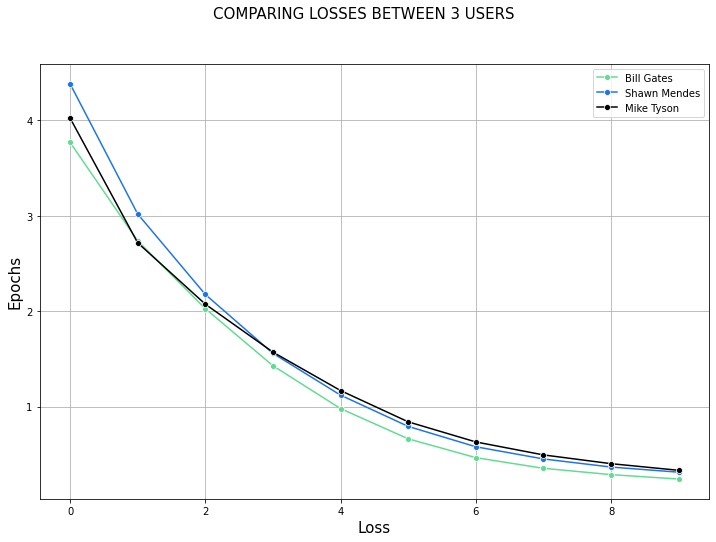

In [ ]:
# Plotting the losses for all 3 user models.

list_of_hist = list()
colors = ["#62DC93", "#1e75e8", "black"]


with open("/content/drive/MyDrive/project_ai_3/BillGates.pkl", 'rb') as f:
    list_of_hist.append( pickle.load(f) )

with open("/content/drive/MyDrive/project_ai_3/ShawnMendes.pkl", 'rb') as f:
    list_of_hist.append( pickle.load(f) )

with open("/content/drive/MyDrive/project_ai_3/MikeTyson.pkl", 'rb') as f:
    list_of_hist.append( pickle.load(f) )

f, ax = plt.subplots(figsize = (12,8))

users = ['Bill Gates','Shawn Mendes','Mike Tyson']

for hist, color, usr in zip(list_of_hist, colors, users):
    # LOSSES
    sbn.lineplot(ax = ax,
                x = list(range(len(hist['loss']))),
                y = hist['loss'],
                 color = color,
                 marker = 'o',
                 label = usr)
    
    ax.set_ylabel('Epochs', fontsize=15)
    ax.set_xlabel('Loss', fontsize=15)


plt.grid(True)
plt.suptitle("COMPARING LOSSES BETWEEN 3 USERS", fontsize=15)
plt.show()

### Observation

We see that the Loss is decreasing consistently but the tweets are does not look good

This means that We must provide better data in order to get better text generation.

Tweets with less or no emoticons, with more words and less links and promotional content, we can 

We can consider following things for data:
- Tweets with less or no emoticons
- Tweets with better content and more words
- Tweets with no or less links of promotional contents

# PART-2 - TWITTER TEXT CLASSIFICATION

## Importing Essential Libraries

For the second part of the project, we need to install few essential Libraries

In [ ]:
!pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JustAnotherArchivist/snscrape.git to /tmp/pip-req-build-pp9cqvb6
  Running command git clone -q https://github.com/JustAnotherArchivist/snscrape.git /tmp/pip-req-build-pp9cqvb6
  Created wheel for snscrape: filename=snscrape-0.4.3.20220107.dev66+ge09aea7-py3-none-any.whl size=68008 sha256=b3034969e389d0f8d692db84d56df6f0d155807fc3b4433abdb6cb20141ba1fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-x8ftw5os/wheels/92/42/87/33fa9b18f7a75d02643a9ca3743339aec9be28c6796267c7d8
Successfully built snscrape


In [ ]:
!pip install emot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 26 kB/s 


In [ ]:
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#libraries needed
import pandas as pd
import snscrape.modules.twitter as sntwitter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

import string
import re
import textblob
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI

from fastai.text.all import *
import warnings
%matplotlib inline


In [ ]:
# downloading the essential modules of nltk.
# after downloading it, no need to re run again, so can be commented out.
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Data Scrapping using snscrape

## Here we are attempting to scrape the twitter data for 6 twitter handles:
1. Elon Musk 
2. Narendra Modi (Prime minister of India) 
3. The Academy Awards 
4. Twitter's own handle 
5. FIFA's twitter handle
6. ANI (Indian twitter news handle)
7. CNN news
8. New York Times
9. Wolf Street Journal
10. TIME

- For the scraping, we are using `snscrape.modules.twitter`, which takes in the query for a handle and gives out the info about it.
- For an easier pre processing method, we are also using `nltk` package, which includes the use of `stopwords` and `nltk.stem.WordNetLemmatizer`.

In [ ]:
# gathering the data for the mentioned twitter handles
# after gathering data, no need to re run this.

'''DO NOT RUN THIS CELL. IT IS FOR SCRAPING'''
'''DATA HAS BEEN ALREADY EXTRACTED'''

# queries that need to be passed to the snscrape
queries = ["(from:elonmusk) lang:en", "(from:TheAcademy) lang:en", 
           "(from:narendramodi) lang:en", "(from:twitter) lang:en", 
           "(from:FIFAcom) lang:en","(from:ANI) lang:en", 
           "(from:cnn) lang:en", "(from:nytimes lang:en)",
           "(from:WSJ lang:en)", "(from:TIME lang:en)"]

tweets = [] #creating an empty list of tweets
for query in queries:
  for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
      if i>20000:
          break
      else:
          tweets.append([tweet.date, tweet.id, tweet.url, tweet.user.username, 
                         tweet.sourceLabel, tweet.user.location, tweet.content, tweet.likeCount, tweet.retweetCount])
          
# creating a dataframe from the tweets list
df = pd.DataFrame(tweets, columns = ['Date', 'ID', 'url', 'username', 'source', 'location', 'tweet', 'num_of_likes', 'num_of_retweet'])
df.to_csv('summarization_updated.csv', mode = 'a')


# DATA PRE-PROCESSING

In [ ]:
# checking the data
df =  pd.read_csv('summarization_updated.csv', encoding = 'unicode_escape')
df.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,Date,ID,url,username,source,location,tweet,num_of_likes,num_of_retweet
0,0,2022-12-12 11:24:29+00:00,1602263113515954177,https://twitter.com/elonmusk/status/1602263113...,elonmusk,Twitter for iPhone,NaN,Truth resonates â¦,4193.0,354.0
1,1,2022-12-12 11:01:19+00:00,1602257284062511104,https://twitter.com/elonmusk/status/1602257284...,elonmusk,Twitter for iPhone,NaN,"@catturd2 Easy to fool people, but it is almos...",12777.0,2505.0
2,2,2022-12-12 01:29:00+00:00,1602113254360162304,https://twitter.com/elonmusk/status/1602113254...,elonmusk,Twitter for iPhone,NaN,@StationCDRKelly I strongly disagree. Forcing ...,471902.0,76981.0
3,3,2022-12-12 01:13:11+00:00,1602109273923678208,https://twitter.com/elonmusk/status/1602109273...,elonmusk,Twitter for iPhone,NaN,@KariLake Reasonable criticism of elections an...,31599.0,3299.0
4,4,2022-12-12 00:16:27+00:00,1602094998215749632,https://twitter.com/elonmusk/status/1602094998...,elonmusk,Twitter for iPhone,NaN,@Erdayastronaut Howâs it looking?,10070.0,412.0


In [ ]:
#check for missing values
df.isnull().sum()

Unnamed: 0            0
Date                  0
ID                    0
url                   1
username              1
source                1
location          76193
tweet                 1
num_of_likes          2
num_of_retweet        2
dtype: int64

In [ ]:
# dropping all the unnecessary columns out of the dataframe
df.drop(["Unnamed: 0","Date","ID","url","source","num_of_likes","num_of_retweet","location"], axis = 1, inplace = True)

In [ ]:
df.head()

,username,tweet
0,elonmusk,Truth resonates â¦
1,elonmusk,"@catturd2 Easy to fool people, but it is almos..."
2,elonmusk,@StationCDRKelly I strongly disagree. Forcing ...
3,elonmusk,@KariLake Reasonable criticism of elections an...
4,elonmusk,@Erdayastronaut Howâs it looking?


In [ ]:
# checking a random tweet from the dataframe
df['tweet'].iloc[2]

'@StationCDRKelly I strongly disagree. Forcing your pronouns upon others when they didnâ\x80\x99t ask, and implicitly ostracizing those who donâ\x80\x99t, is neither good nor kind to anyone.\n\nAs for Fauci, he lied to Congress and funded gain-of-function research that killed millions of people. Not awesome imo.'

* As we can see from the printed tweet, it contains a lot of noise in the form of special characters and emojis, etc. This needs to be removed so that it does not halt or cause any kind of training error in the later stages

## Pre processing of the Tweets

* For preprocessing we need to first initialize we packages-
1. `nltk.corpus.stopwords` - and we are getting all the stopwords for English vocabulary
2. `emot.emo_unicode.UNICODE_EMOJI` - the emojis which are most prevelant on social media
3. `WordNetLemmatizer` - to get the core word in some of compound words (for example - "have" from "having", etc.)

In [ ]:
#initialising the stopwords, emojis and lemmatizer
eng_stop_words = list(stopwords.words('english'))

emoji = list(UNICODE_EMOJI.keys())

lemmatizer = WordNetLemmatizer() 

* Next we create a function, which takes in a sentence, lowers it, removes all non alphanumeric characters and @usernames (reply to other twitter handles) 

In [ ]:
# function for preprocessing tweet in preparation for tweets
def processed_tweets(text):

    # changing tweet text to small letters
    text = str(text).lower()

    # Removing @ and links 
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text)

    # removing repeating characters
    text = re.sub(r'\@\w+|\#\w+|\d+', '', text)

    # removing non alphanumeric characters
    text = ''.join(char for char in text if char.isalnum() or char == ' ')

    # removing punctuation and numbers
    punct = str.maketrans('', '', string.punctuation+string.digits)
    text = text.translate(punct)

    # splitting the text based on whitespaces
    word_list = text.split()

    # filtering the words which are not in emoji
    filtered_words = [w for w in word_list if w not in emoji]

    # joining the words together with whitespace
    new_text = " ".join(filtered_words)

    return new_text

In [ ]:
# applying the processing function to the tweets in dataframe
df['processed_tweets'] = df['tweet'].apply(processed_tweets)

In [ ]:
# checking the processed tweet
df['processed_tweets'].iloc[2]

'i strongly disagree forcing your pronouns upon others when they didnât ask and implicitly ostracizing those who donât is neither good nor kind to anyoneas for fauci he lied to congress and funded gainoffunction research that killed millions of people not awesome imo'

* Now we will attempt to create a Word Cloud for all the tweets and find the top 200 words that are used in the dataset

In [ ]:
# creating a list of all the tweets and creating a single text file
all_tweets_list = df['processed_tweets'].tolist()
tweets_list = " ".join(all_tweets_list)

In [ ]:
# to create the wordcloud we remove all the stopwords and getting root word using lemmatizer
tweets_list_words = tweets_list.split()
req_words = [w for w in tweets_list_words if w not in eng_stop_words]
origin_words = [lemmatizer.lemmatize(w) for w in req_words]
cloud_text = " ".join(origin_words)

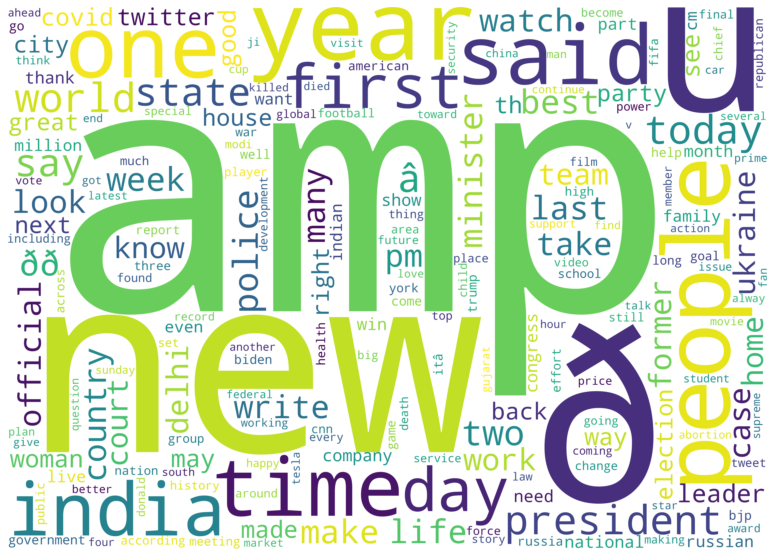

In [ ]:
# Displaying the most talked about word in a word cloud 
# Instantiate the Twitter word cloud object
w_cloud = WordCloud(collocations = False,max_words=200, background_color = 'white', width = 7000, height = 5000).generate(cloud_text)

# Display the generated Word Cloud
plt.figure(figsize = (20,10))
plt.imshow(w_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# adding start and end tokens to the dataset
df['model feed'] = "<s> " + df['processed_tweets'] + " </s>"

In [ ]:
df.head()

,username,tweet,processed_tweets,model feed
0,elonmusk,Truth resonates â¦,truth resonates â,<s> truth resonates â </s>
1,elonmusk,"@catturd2 Easy to fool people, but it is almos...",easy to fool people but it is almost impossibl...,<s> easy to fool people but it is almost impos...
2,elonmusk,@StationCDRKelly I strongly disagree. Forcing ...,i strongly disagree forcing your pronouns upon...,<s> i strongly disagree forcing your pronouns ...
3,elonmusk,@KariLake Reasonable criticism of elections an...,reasonable criticism of elections and judicial...,<s> reasonable criticism of elections and judi...
4,elonmusk,@Erdayastronaut Howâs it looking?,howâs it looking,<s> howâs it looking </s>


## Text classification using ULMFiT

### Creating a Snetiment column for the tweets

* For Text classification, we will try to classify the sentiment of the tweet posted by each twitter handle.
* To achieve this, first we need to get the polarity of the tweet
* The polarity of the tweet is divided into three parts:
  1. `Positive` - if the polarity is greater than zero
  2. `Neutral` - if the polarity is equal to zero
  3. `Negative` - if the polarity is less than zero

* For getting the polarity, we are using the `textblob` library.

In [ ]:
# create a function for polarity calculation of tweets
def polarity(tweet):
  return TextBlob(tweet).sentiment.polarity

# create a mapping function based on polarity
def sentiment(pol):
  if pol < 0:
    return 0
  elif pol == 0:
    return 1
  else:
    return 2

In [ ]:
# mapping both the functions to get the sentiment of our tweets
df['polarity'] = df['processed_tweets'].apply(polarity)
df['sentiment'] = df['polarity'].apply(sentiment)

In [ ]:
df.head()

,username,tweet,processed_tweets,model feed,polarity,sentiment
0,elonmusk,Truth resonates â¦,truth resonates â,<s> truth resonates â </s>,0.000000,1
1,elonmusk,"@catturd2 Easy to fool people, but it is almost impossible to convince people that they have been fooled",easy to fool people but it is almost impossible to convince people that they have been fooled,<s> easy to fool people but it is almost impossible to convince people that they have been fooled </s>,-0.116667,0
2,elonmusk,"@StationCDRKelly I strongly disagree. Forcing your pronouns upon others when they didnât ask, and implicitly ostracizing those who donât, is neither good nor kind to anyone.\n\nAs for Fauci, he lied to Congress and funded gain-of-function research that killed millions of people. Not awesome imo.",i strongly disagree forcing your pronouns upon others when they didnât ask and implicitly ostracizing those who donât is neither good nor kind to anyoneas for fauci he lied to congress and funded gainoffunction research that killed millions of people not awesome imo,<s> i strongly disagree forcing your pronouns upon others when they didnât ask and implicitly ostracizing those who donât is neither good nor kind to anyoneas for fauci he lied to congress and funded gainoffunction research that killed millions of people not awesome imo </s>,0.206667,2
3,elonmusk,"@KariLake Reasonable criticism of elections and judicial challenges are, of course, lawful. That seems to be the case here.\n\nClear incitement to violence will result in suspension and significant deception should result in a @CommunityNotes correction.",reasonable criticism of elections and judicial challenges are of course lawful that seems to be the case hereclear incitement to violence will result in suspension and significant deception should result in a correction,<s> reasonable criticism of elections and judicial challenges are of course lawful that seems to be the case hereclear incitement to violence will result in suspension and significant deception should result in a correction </s>,0.191667,2
4,elonmusk,@Erdayastronaut Howâs it looking?,howâs it looking,<s> howâs it looking </s>,0.000000,1


### USING ULMFiT

* Universal Language Model Fine-tuning, or ULMFiT, is an architecture and transfer learning method that can be applied to NLP tasks. 
* It involves a 3-layer AWD-LSTM architecture for its representations. 
* The training consists of three steps: 
    1. general language model pre-training on a Wikipedia-based text. 
    2. fine-tuning the language model on a target task, and 
    3. fine-tuning the classifier on the target task.
    
For more information regarding the ULMFit, you can refer to the fastai official documentation [here](https://docs.fast.ai/tutorial.text.html)


<img src="https://docs.fast.ai/images/ulmfit.png" />

In [ ]:
# creating the sentiment dataset based on previous data
s_df = df[['processed_tweets','sentiment']]

In [ ]:
s_df.head()

,processed_tweets,sentiment
0,truth resonates â,1
1,easy to fool people but it is almost impossible to convince people that they have been fooled,0
2,i strongly disagree forcing your pronouns upon others when they didnât ask and implicitly ostracizing those who donât is neither good nor kind to anyoneas for fauci he lied to congress and funded gainoffunction research that killed millions of people not awesome imo,2
3,reasonable criticism of elections and judicial challenges are of course lawful that seems to be the case hereclear incitement to violence will result in suspension and significant deception should result in a correction,2
4,howâs it looking,1


In [ ]:
# creating a Dataloader for language model
lm_data = TextDataLoaders.from_df(s_df, path = "", is_lm=True, valid_pct=0.3, bs=128, seq_len=80)

In [ ]:
# showing 5 texts with tokenized data from dataloader
lm_data.show_batch(max_n=5)

,text,text_
0,xxbos tropical storm ian is forecast to reach up to category hurricane strength before hitting florida next week xxbos we tried the worldâs first labgrown steak no cows required xxbos were unhappy as senior leaders were nt consulted before taking decision on jampk pcc xxunk resigned from partys coordination committee as protest against recent announcements of pcc chief i ve resigned from congress primary xxunk exmla haji abdul rashid dar xxbos dear xxunk vote in gave india a strong government,tropical storm ian is forecast to reach up to category hurricane strength before hitting florida next week xxbos we tried the worldâs first labgrown steak no cows required xxbos were unhappy as senior leaders were nt consulted before taking decision on jampk pcc xxunk resigned from partys coordination committee as protest against recent announcements of pcc chief i ve resigned from congress primary xxunk exmla haji abdul rashid dar xxbos dear xxunk vote in gave india a strong government that
1,3 o on eclipse week xxbos a dogs eyes may well up with tears of happiness when reunited with its owner after a period of absence new research from japanese scientists suggests xxbos quiz records in xxrep 4 â q lionel messi has scored goals for â the secondmost a player has scored for one club behind peleâs for ðwhich of the following players also features in the top five xxbos what i find most surprising is that cnn still,o on eclipse week xxbos a dogs eyes may well up with tears of happiness when reunited with its owner after a period of absence new research from japanese scientists suggests xxbos quiz records in xxrep 4 â q lionel messi has scored goals for â the secondmost a player has scored for one club behind peleâs for ðwhich of the following players also features in the top five xxbos what i find most surprising is that cnn still exists
2,terrorist attack turkish vice president xxunk xxunk said according to state news agency xxunk xxbos inflation is coming for thanksgiving dinner a birdflu outbreak has killed millions of turkeys lowering supplies and lifting prices to their highest levels ever xxbos released âthe birds of xxunk xxunk a book by scientists of gujarat institute of desert ecology guide xxbos chandrayaan is almost ready final integration and testing almost complete still some more tests are pending so we want to do it,attack turkish vice president xxunk xxunk said according to state news agency xxunk xxbos inflation is coming for thanksgiving dinner a birdflu outbreak has killed millions of turkeys lowering supplies and lifting prices to their highest levels ever xxbos released âthe birds of xxunk xxunk a book by scientists of gujarat institute of desert ecology guide xxbos chandrayaan is almost ready final integration and testing almost complete still some more tests are pending so we want to do it a
3,years people know that bjp means stability priority to xxunk of himachal have decided to form bjp government again pm modi in mandi xxbos ukrainians must endure a brutal filtration process to escape russianheld territory heres what that means xxbos the entire xxunk of ins vikrant around kms in length has been made in india this is a big achievement for us xxunk steel has also been made in india with the help of indian navy drdo amp sail it,people know that bjp means stability priority to xxunk of himachal have decided to form bjp government again pm modi in mandi xxbos ukrainians must endure a brutal filtration process to escape russianheld territory heres what that means xxbos the entire xxunk of ins vikrant around kms in length has been made in india this is a big achievement for us xxunk steel has also been made in india with the help of indian navy drdo amp sail it can
4,a statement from her family and friends xxbos good analysis although i think we should wait until fsd is a bit more mature xxbos itâs been a xxunk xxunk church lost over ââ kilos thanks to football and is using the beautiful game to help countles

The rules are all listed below, here is the meaning of the special tokens:

* `UNK (xxunk)` is for an unknown word (one that isn't present in the current vocabulary)
* `PAD (xxpad)` is the token used for padding, if we need to regroup several texts of different lengths in a batch
* `BOS (xxbos)` represents the beginning of a text in your dataset
* `TK_MAJ (xxmaj)` is used to indicate the next word begins with a capital in the original text
* `TK_REP (xxrep)` is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
* `TK_WREP(xxwrep)` is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})


In [ ]:
# starting a language model learner
learn_lm = language_model_learner(lm_data, AWD_LSTM, metrics=[accuracy, Perplexity()], path="", wd=0.1).to_fp16()

the minimum learning rate for the Language learning model is : SuggestedLRs(minimum=0.04365158379077912)


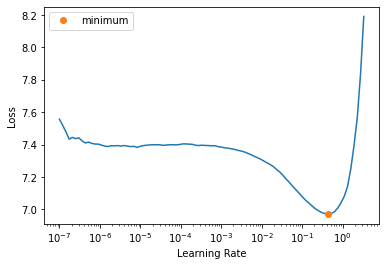

In [ ]:
# finding the best learning rate for the model
minimum_lr = learn_lm.lr_find(suggest_funcs=(minimum))
print(f"the minimum learning rate for the Language learning model is : {minimum_lr:}")

In [ ]:
# structure of the LSTM model
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(42448, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(42448, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=42448, bias=True)
    (output_dp): RNNDropout()
  )
)

In [ ]:
# fitting the model for 2 epochs
learn_lm.fit_one_cycle(2, minimum_lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.651651,5.233630,0.210907,187.472031,03:58
1,5.191182,4.927073,0.233316,137.975067,03:57


In [ ]:
# unfreezing all the layers and fitting the model for 10 epochs
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, minimum_lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.738030,4.887169,0.231873,132.577759,04:13
1,5.305124,5.273299,0.199272,195.058441,04:47
2,5.414397,5.263885,0.202781,193.230652,04:36
3,5.321375,5.197147,0.206745,180.755875,04:43
4,5.198854,5.075749,0.215096,160.092041,04:30
5,5.019072,4.923451,0.229090,137.476288,04:41
6,4.805766,4.762256,0.243596,117.009560,04:08
7,4.562376,4.603254,0.260908,99.808548,04:11
8,4.285184,4.498515,0.273981,89.883522,04:09
9,4.101486,4.482838,0.276846,88.485451,04:09


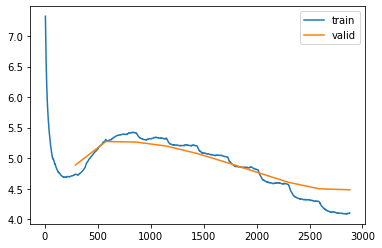

In [ ]:
# get the language model loss for both train and validation
learn_lm.recorder.plot_loss()

In [ ]:
# saving the language model as the encoder to be used for text classification
learn_lm.save_encoder('language_model')

In [ ]:
# generating a pprediction from language model
sample = "This years winner"
n = 40
learn_lm.predict(sample, n)

'This years winner after a day game we review the crown to play the cocreator and and thereâs lively alliances in your garden meaty workout traits with much of your nails while eating them use with your local zoom keeping surfing on'

In [ ]:
learn_lm.predict("the award for", 40)

'the award for best picture goes to and that could be remarkably annoying for the room resulting in an early days luxury sellers on netflix have writing outsideâ and it has rolled out in multiple sectors as a climatefriendly project'

In [ ]:
# creating the dataloaders for our text classifier model
cls_data = TextDataLoaders.from_df(s_df, text_vocab=lm_data.vocab, text_col='processed_tweets', labelcol='sentiment', bs=128, seq_len=80)

In [ ]:
# showing the data from our dataloaders 
cls_data.show_batch(max_n=5)

,text,category
0,xxbos àà¾ xxrep 4 à àµ xxrep 3 à ¾ xxrep 4 à xxrep 4 à ¾à àà xxunk àà xxrep 4 à ¾à àà xxunk xxrep 3 à xxunk xxrep 3 à xxrep 4 à xxunk àà xxrep 4 à xxrep 6 à à¹à àà àµà xxunk xxunk xxrep 4 à xxunk xxrep 3 à phase of the jharkhand elections is in progress i urge those whose constituencies go to the polls today to vote in large numbers amp enrich the festival of democracy,2
1,xxbos kerala hc dismisses the pil seeking to set a time limit for the gov for taking a decision on bills passed by assembly while dismissing the pil court observed its not the duty of court to fix a time limit to decide on bills by the governor amp its for the legislature to do so,1
2,xxbos i suggested secy blinken that if there was something we could do from indian govt to help the us govt deal with this issue in a better way we would be very open to doing it but this is an issue where its mainly for the us to dowell be supportive eam on visa issue,2
3,xxbos we ve calculated that mlas have come to their party bjp now if they would ve given rs cr to each mla then they ve bought mlas worth rs crores that s why there s inflation as they re using all the money to buy mlas at expense of common xxunk cm arvind kejriwal,1
4,xxbos all i can say about rahul gandhis comment on veer savarkar is that he has very less historical knowledge maybe someone read out history for him amp he did nt read it on his own he committed a grave sin by insulting savarkar i think hell have to pay for it politically assam cm,0


In [ ]:
# creating a text classification learner
learn_cls = text_classifier_learner(cls_data, AWD_LSTM, drop_mult=0.4, metrics=accuracy).to_fp16()

In [ ]:
# loading the encoder
learn_cls.load_encoder("language_model")

In [ ]:
# fitting the classifier model for one epoch
learn_cls.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.813925,0.800559,0.652791,03:01


the minimum learning rate for the Text classification model is : SuggestedLRs(minimum=0.00036307806149125097)


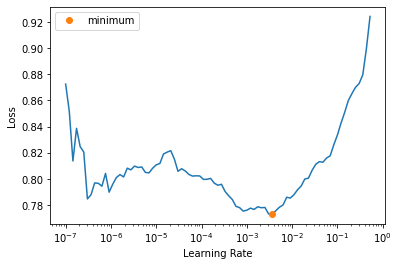

In [ ]:
# getting the new learning rate for our model
new_minimum_lr = learn_cls.lr_find(suggest_funcs=(minimum))
print(f"the minimum learning rate for the Text classification model is : {new_minimum_lr:}")

In [ ]:
# freezing until the last two layers and fitting to 1 epoch
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(1, new_minimum_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.718108,0.701095,0.707835,03:04


In [ ]:
# freezing until the last three layers and fitting to 10 epoch
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(10, new_minimum_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.654306,0.643788,0.735903,03:09
1,0.530503,0.493885,0.803076,03:15
2,0.407017,0.357690,0.869548,03:11
3,0.299026,0.281324,0.900081,03:12
4,0.259490,0.249729,0.915292,03:10
5,0.214022,0.227523,0.923723,03:11
6,0.183579,0.220231,0.927757,03:12
7,0.157843,0.219208,0.928766,03:12
8,0.151579,0.216802,0.930502,03:12
9,0.137038,0.216633,0.930950,03:10


In [ ]:
# predicting the sentiment of the tweet
learn_cls.predict("This was not how it was meant to be")

('1', tensor(1), tensor([0.0028, 0.9859, 0.0113]))

## Conclusion
* ULMFiT (Universal Language Model Fine-tuning) is a technique for natural language processing (NLP) tasks that was developed by researchers at fast.ai. 

* It involves fine-tuning a pre-trained language model on a specific NLP task, such as sentiment analysis or named entity recognition. This allows the model to achieve strong performance on the specific task while still maintaining a general understanding of the structure of language. The technique has been shown to significantly improve the performance of NLP models on a variety of tasks.

* We created our own ULMFiT model based on the tweets generated by snscraper and successfully created a text classifier learner.

* We can see that the ULMFiT model is able to predict the sentiment of a tweet with ~93% accuracy, which is fairly good score for a model to achieve. To test it out, we passed a neutral sentence and it predicted correctly
